# Explicando Previsões de Câncer de Mama com Redes Neurais e SHAP

Este notebook demonstra a aplicação de técnicas de Inteligência Artificial Explicável (XAI) para interpretar as previsões de um modelo de deep learning ResNet-50, treinado para classificar imagens histopatológicas de câncer de mama (dataset BreaKHis) em 'benigno' ou 'maligno'.

Enquanto modelos de redes neurais profundas alcançam alta acurácia, eles frequentemente operam como "caixas-pretas", tornando suas decisões difíceis de entender. O objetivo deste projeto é utilizar o framework SHAP (SHapley Additive exPlanations) para "abrir" essa caixa-preta, fornecendo explicações visuais e intuitivas para as previsões do modelo.

O processo é dividido em quatro etapas principais:

- Preparação do Ambiente: Configuração do ambiente e carregamento do modelo ResNet-50 já treinado.
- Pré-processamento de Dados: Seleção de um conjunto de imagens de amostra e aplicação das transformações necessárias para que sejam compatíveis com o modelo.
- Implementação do SHAP: Utilização do GradientExplainer para calcular a contribuição de cada pixel na decisão do modelo para cada imagem selecionada.
- Visualização e Interpretação: Geração de mapas de calor que destacam as regiões da imagem que mais influenciaram a previsão, permitindo uma análise detalhada do comportamento do modelo.

Como resultado, para cada imagem analisada, o notebook gera não apenas a previsão da classe, mas também um mapa visual que responde à pergunta: "Por que o modelo tomou essa decisão?". Essa abordagem aumenta a confiança e a transparência do modelo, sendo um passo fundamental para a validação e aplicação de sistemas de IA em domínios críticos como a medicina.

Importação das bibliotecas necessárias

In [1]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import shap
import torch
import torch.nn as nn
from PIL import Image
from torchvision import models, transforms

import kagglehub

## Etapa 0: Aquisição e Organização do Dataset

O objetivo desta etapa inicial é preparar os dados, realizando o download do dataset BreakHis e reorganizando sua estrutura de arquivos para um formato adequado.

Download do dataset BreakHis a partir do repositório do Kaggle utilizando a biblioteca kagglehub.

In [2]:
caminho = kagglehub.dataset_download("ambarish/breakhis")

Abaixo, ocorre a definição das variáveis de caminho para o dataset de origem e para o diretório de destino, que será usado para organizar os dados. Em seguida, a estrutura de pastas de destino é criada, com subdiretórios separados para cada uma das classes do problema ("benign" e "malignant").

In [3]:
caminho_dados = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
caminho_destino = '/kaggle/working/data'
classes = ['benign', 'malignant']

for classe in classes:
    os.makedirs(os.path.join(caminho_destino, classe), exist_ok=True)

Para simplificar a estrutura do dataset, é criada uma função que navega pela organização original de pastas, a qual é dividida por subtipo, paciente e magnificação. Esta função extrai apenas as imagens com magnificação de 40X, renomeia cada arquivo para garantir sua unicidade e os copia para os diretórios de destino (benign e malignant) previamente criados.

In [4]:
def copiar_imagens(classe, magnificacao='40X'):
    caminho_dados_sob = os.path.join(caminho_dados, classe, 'SOB')
    caminho_destino_classe = os.path.join(caminho_destino, classe)

    dirs_subtipos = os.listdir(caminho_dados_sob)

    for subtipo in dirs_subtipos:
        caminho_subtipo = os.path.join(caminho_dados_sob, subtipo)

        dirs_pacientes = os.listdir(caminho_subtipo)
        for id_paciente in dirs_pacientes:
            caminho_mag = os.path.join(caminho_subtipo, id_paciente, magnificacao)

            if os.path.isdir(caminho_mag):
                imagens = [f for f in os.listdir(caminho_mag) if f.endswith('.png')]
                for nome_imagem in imagens:
                    arquivo_origem = os.path.join(caminho_mag, nome_imagem)
                    nome_imagem_destino = f"{id_paciente}-{subtipo}-{nome_imagem}"
                    arquivo_destino = os.path.join(caminho_destino_classe, nome_imagem_destino)
                    shutil.copy(arquivo_origem, arquivo_destino)

copiar_imagens('benign')
copiar_imagens('malignant')

## Etapa 1: Preparação do Ambiente e Carregamento do Modelo

Nesta etapa, o ambiente de trabalho é configurado para garantir a consistência dos resultados e o melhor desempenho possível. As sementes aleatórias são fixadas para reprodutibilidade e o hardware de processamento (GPU ou CPU) é selecionado. Em seguida, o modelo ResNet-50 treinado é carregado em memória, tendo sua camada final adaptada ao problema específico, e é preparado para realizar previsões.

Abaixo, há a configuração do ambiente de execução. As sementes aleatórias são definidas para garantir a reprodutibilidade dos experimentos. Além disso, o código verifica a disponibilidade de uma GPU (CUDA) e seleciona o dispositivo apropriado (GPU ou CPU) para o processamento.

In [5]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {dispositivo}")

Dispositivo utilizado: cuda


Carregamento do modelo ResNet-50. A arquitetura é instanciada e sua camada de classificação final é ajustada para o número de classes do dataset BreakHis. Em seguida, os pesos do modelo, previamente treinados e salvos em um arquivo, são carregados. Por fim, o modelo é movido para o dispositivo de processamento definido e colocado em modo de avaliação (eval), pronto para realizar inferências.

In [6]:
modelo = models.resnet50()

num_ftrs = modelo.fc.in_features
modelo.fc = nn.Linear(num_ftrs, len(classes))

caminho_modelo = '/content/modelo_final_resnet50_breakhis.pth'
modelo.load_state_dict(torch.load(caminho_modelo, map_location=dispositivo))
modelo = modelo.to(dispositivo)

modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Etapa 2: Pré-Processamento e Seleção de Imagens para Classificação

Nesta seção, o foco é preparar os dados de entrada para o modelo. Primeiro, define-se uma pipeline de pré-processamento padrão, que redimensiona, converte e normaliza as imagens para o formato esperado pela ResNet. Em seguida, uma amostra aleatória de imagens, contendo exemplos de cada classe, é selecionada dos diretórios de dados. Essas imagens são então processadas e agrupadas em um lote (batch), preparando-as para a etapa de explicação.

Aqui, é definida a sequência de transformações que serão aplicadas às imagens. Esta pipeline garante que os dados de entrada tenham o formato e a distribuição de valores que o modelo ResNet-50 espera, incluindo o redimensionamento para 224x224 pixels, a conversão para o formato de tensor e a normalização com as médias e desvios padrão do dataset ImageNet.

In [7]:
TAMANHO_IMAGEM = 224

val_test_transforms = transforms.Compose([
    transforms.Resize((TAMANHO_IMAGEM, TAMANHO_IMAGEM)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Criação de uma função para pré-processar imagens individuais, aplicando a pipeline de transformações definida anteriormente. O código, então, lista os caminhos das imagens benignas e malignas e seleciona aleatoriamente um pequeno subconjunto (duas de cada classe) para ser explicado. Por fim, essas imagens selecionadas são processadas e agrupadas em um único tensor (lote), prontas para serem enviadas ao modelo.

In [8]:
def preprocessar_imagem(caminho_imagem):
    img = Image.open(caminho_imagem).convert('RGB')
    tensor_img = val_test_transforms(img).unsqueeze(0)
    return tensor_img.to(dispositivo)

caminho_benign = os.path.join(caminho_destino, 'benign')
caminho_malignant = os.path.join(caminho_destino, 'malignant')

imagens_benignas = [os.path.join(caminho_benign, f) for f in os.listdir(caminho_benign)]
imagens_malignas = [os.path.join(caminho_malignant, f) for f in os.listdir(caminho_malignant)]

imagens_para_explicar_paths = random.sample(imagens_benignas, 2) + random.sample(imagens_malignas, 2)
imagens_para_explicar_tensors = torch.cat([preprocessar_imagem(p) for p in imagens_para_explicar_paths])

print(f"Selecionadas {len(imagens_para_explicar_paths)} imagens para análise SHAP.")
print("Caminhos das imagens:", imagens_para_explicar_paths)

Selecionadas 4 imagens para análise SHAP.
Caminhos das imagens: ['/kaggle/working/data/benign/SOB_B_PT_14-21998AB-phyllodes_tumor-SOB_B_PT-14-21998AB-40-055.png', '/kaggle/working/data/benign/SOB_B_TA_14-16184-tubular_adenoma-SOB_B_TA-14-16184-40-018.png', '/kaggle/working/data/malignant/SOB_M_DC_14-15572-ductal_carcinoma-SOB_M_DC-14-15572-40-018.png', '/kaggle/working/data/malignant/SOB_M_DC_14-20629-ductal_carcinoma-SOB_M_DC-14-20629-40-028.png']


## Etapa 3: Implementação do SHAP

Nesta etapa, o SHAP (SHapley Additive exPlanations) é utilizado para gerar as explicações das previsões do modelo. Primeiramente, um conjunto de dados de referência ("background") é criado a partir de uma amostra aleatória de imagens. Em seguida, o GradientExplainer, um algoritmo SHAP otimizado para modelos de deep learning, é inicializado com o modelo e os dados de referência. Por fim, este explicador é usado para calcular os valores SHAP para o lote de imagens selecionado, atribuindo a cada pixel uma pontuação de importância para a previsão de cada classe.

In [10]:
background_paths = random.sample(imagens_benignas + imagens_malignas, 20)
background_tensors = torch.cat([preprocessar_imagem(p) for p in background_paths]).to(dispositivo)

explainer = shap.GradientExplainer(modelo, background_tensors)
shap_values = explainer.shap_values(imagens_para_explicar_tensors)

print(f"Formato da saída SHAP para a classe 0 (benign): {shap_values[0].shape}")
print(f"Formato da saída SHAP para a classe 1 (malignant): {shap_values[1].shape}")

Formato da saída SHAP para a classe 0 (benign): (3, 224, 224, 2)
Formato da saída SHAP para a classe 1 (malignant): (3, 224, 224, 2)


## Etapa 4: Visualização e Interpretação dos Resultados

Esta seção final é dedicada a traduzir os valores SHAP numéricos em visualizações interpretáveis. Primeiro, os dados (imagens e valores SHAP) são pré-processados, revertendo a normalização e ajustando o formato para exibição. Em seguida, para cada imagem de amostra, o código gera um gráfico que sobrepõe a explicação SHAP, destacando as regiões de pixels que mais contribuíram para a decisão do modelo, juntamente com a previsão e a confiança da rede.

Preparação dos dados para a visualização. Os valores SHAP e os tensores de imagem são convertidos do formato (Canais, Altura, Largura), utilizado pelo PyTorch, para o formato (Altura, Largura, Canais), esperado pelas bibliotecas de plotagem. Além disso, a normalização aplicada às imagens é revertida para que elas possam ser exibidas com suas cores originais.

In [11]:
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 5:
    shap_values_list = [shap_values[..., i] for i in range(shap_values.shape[-1])]
else:
    shap_values_list = shap_values

shap_values_plot = [s.transpose(0, 2, 3, 1) for s in shap_values_list]

imagens_para_plotar = imagens_para_explicar_tensors.cpu().numpy().transpose(0, 2, 3, 1)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
imagens_para_plotar = std * imagens_para_plotar + mean
imagens_para_plotar = np.clip(imagens_para_plotar, 0, 1)

Geração e exibição das visualizações SHAP. O código itera sobre cada imagem da amostra, primeiro obtendo a previsão do modelo e a confiança associada. Em seguida, para cada imagem, exibe um resumo textual e utiliza a função shap.image_plot para gerar um gráfico comparativo. Este gráfico destaca as regiões de pixels em vermelho (que apoiam a previsão) e em azul (que se opõem a ela), tornando a decisão do modelo visualmente interpretável.


Imagem 1: SOB_B_PT_14-21998AB-phyllodes_tumor-SOB_B_PT-14-21998AB-40-055.png
Classe Real: Benign
Previsão do Modelo: benign com 52.43% de confiança.
Visualização SHAP:


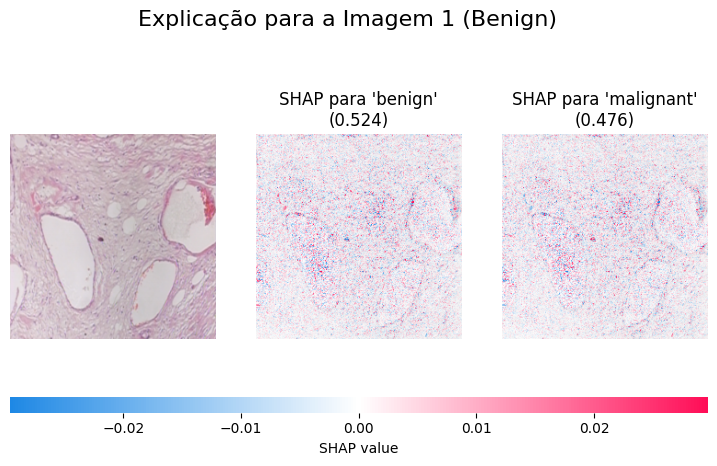


Imagem 2: SOB_B_TA_14-16184-tubular_adenoma-SOB_B_TA-14-16184-40-018.png
Classe Real: Benign
Previsão do Modelo: benign com 99.47% de confiança.
Visualização SHAP:


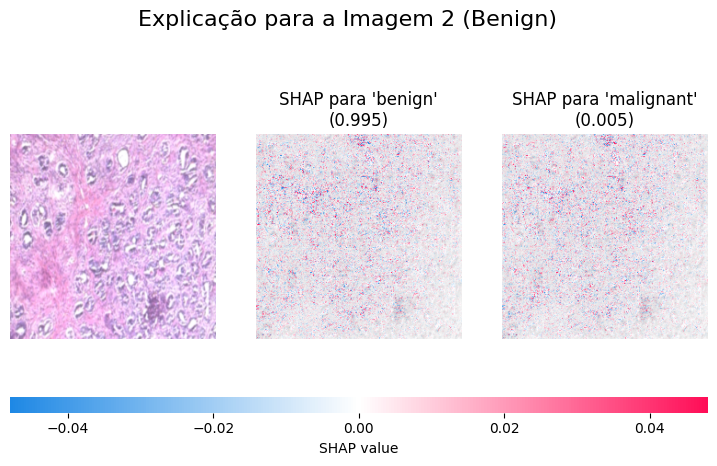


Imagem 3: SOB_M_DC_14-15572-ductal_carcinoma-SOB_M_DC-14-15572-40-018.png
Classe Real: Malignant
Previsão do Modelo: malignant com 97.58% de confiança.
Visualização SHAP:


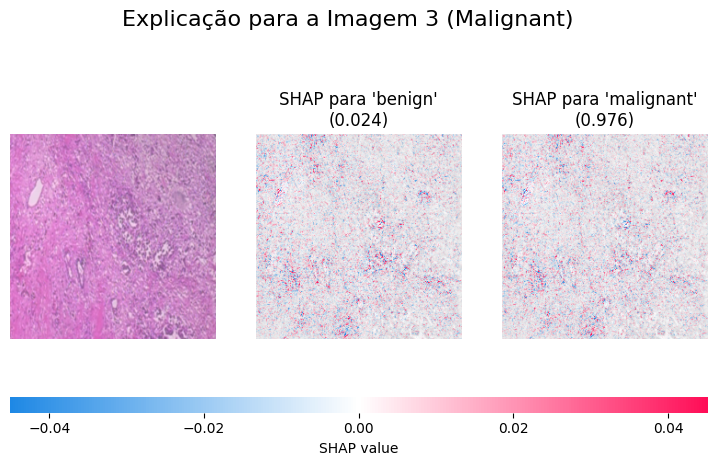


Imagem 4: SOB_M_DC_14-20629-ductal_carcinoma-SOB_M_DC-14-20629-40-028.png
Classe Real: Malignant
Previsão do Modelo: malignant com 99.23% de confiança.
Visualização SHAP:


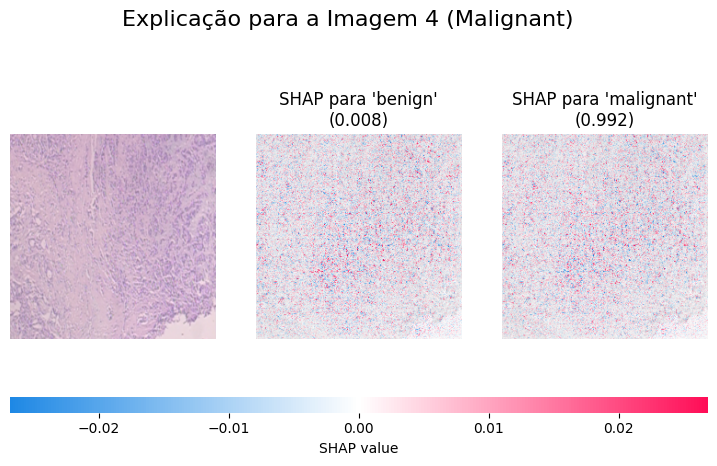

In [12]:
with torch.no_grad():
    logits = modelo(imagens_para_explicar_tensors)
    probabilidades = torch.softmax(logits, dim=1).cpu().numpy()
    predicoes = np.argmax(probabilidades, axis=1)

class_names = [f"SHAP para '{c}'" for c in classes]

for i in range(len(imagens_para_plotar)):
    caminho_real = os.path.basename(imagens_para_explicar_paths[i])
    classe_real = "Benign" if "benign" in imagens_para_explicar_paths[i] else "Malignant"
    classe_predita = classes[predicoes[i]]
    confianca = probabilidades[i][predicoes[i]] * 100

    print(f"\nImagem {i+1}: {caminho_real}")
    print(f"Classe Real: {classe_real}")
    print(f"Previsão do Modelo: {classe_predita} com {confianca:.2f}% de confiança.")
    print("Visualização SHAP:")

    labels_plot = np.array([[f"{c}\n({probabilidades[i][j]:.3f})" for j, c in enumerate(class_names)]])

    shap.image_plot(
        shap_values=[s[i:i+1] for s in shap_values_plot],
        pixel_values=imagens_para_plotar[i:i+1],
        labels=labels_plot,
        show=False
    )
    plt.suptitle(f"Explicação para a Imagem {i+1} ({classe_real})", fontsize=16, y=1.0)
    plt.show()